In [579]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 25)

from pipeline import team_metadata, score_by_score


In [580]:
## Get records by date
importlib.reload(team_metadata)
games = team_metadata.get_game_by_game("2021-22")
games['winner'] = games.apply(lambda x: x['home'] if x['home_win'] else x['vis'], axis=1)
games.tail()



,game_id,date,home,vis,home_score,vis_score,home_win,winner
903,22100909,2022-02-26,CHI,MEM,110,116,False,MEM
904,22100910,2022-02-26,MIL,BKN,123,126,False,BKN
905,22100911,2022-02-26,DEN,SAC,115,110,True,DEN
906,22100912,2022-02-27,NYK,PHI,109,125,False,PHI
907,22100913,2022-02-27,PHX,UTA,114,118,False,UTA


In [587]:
def sigmoid(x, a=0, b=1):
    return 1/(1+np.exp(-(a + b*x)))


In [701]:
games.loc[len(games)-1, ['home', 'vis', 'home_win']] = ['PHX', 'UTA', False]
games

,game_id,date,home,vis,home_score,vis_score,home_win,winner
0,22100001,2021-10-19,MIL,BKN,127,104,True,MIL
1,22100002,2021-10-19,LAL,GSW,114,121,False,GSW
2,22100003,2021-10-20,CHA,IND,123,122,True,CHA
3,22100004,2021-10-20,DET,CHI,88,94,False,CHI
4,22100005,2021-10-20,NYK,BOS,138,134,True,NYK
...,...,...,...,...,...,...,...,...
903,22100909,2022-02-26,CHI,MEM,110,116,False,MEM
904,22100910,2022-02-26,MIL,BKN,123,126,False,BKN
905,22100911,2022-02-26,DEN,SAC,115,110,True,DEN
906,22100912,2022-02-27,NYK,PHI,109,125,False,PHI


In [719]:
def get_rankings(games, n_iters=2, sigmoid_a=0.28, sigmoid_b=1):
    ranking_distns = defaultdict(lambda: {'mu':0, 'sigma':1}) # team ranking distributions
    for i in range(n_iters):
        for _, game in games.iterrows():
            home, vis, home_win = game[['home', 'vis', 'home_win']]

            # Get prior dist'ns
            w = .01
            qh = np.arange(-5, 5, w)
            qv = np.arange(-5, 5, w)
            h_prior = norm.pdf(qh, loc=ranking_distns[home]['mu'], scale=ranking_distns[home]['sigma'])
            v_prior = norm.pdf(qv, loc=ranking_distns[vis]['mu'], scale=ranking_distns[vis]['sigma'])

            # Get posterior
            meshgrid = np.meshgrid(qh, qv)
            qh_minus_qv = meshgrid[0] - meshgrid[1] # matrix of quality differences
            outcome_probs = sigmoid(qh_minus_qv, a=sigmoid_a, b=sigmoid_b) # row represents qv (lowest to highest), col represents qh (lowest to highest)
            outcome_probs = outcome_probs if home_win else 1-outcome_probs
            h_post_over_v = h_prior * outcome_probs # posteriors—row represents qv, column represents qh
            v_post_over_h = v_prior[:,np.newaxis] * outcome_probs # posteriors—row represents qv, column represents qh        
            h_post = (h_post_over_v * v_prior[:, np.newaxis]).sum(0)
            v_post = (v_post_over_h * h_prior).sum(1)
            h_post /= (h_post*w).sum()
            v_post /= (v_post*w).sum()
            ranking_distns[home] = {'mu': w*(qh*h_post).sum(), 'sigma': np.sqrt(w*np.sum((qh**2)*h_post) - (w*np.sum(qh*h_post))**2)}
            ranking_distns[vis] = {'mu': w*(qv*v_post).sum(), 'sigma': np.sqrt(w*np.sum((qv**2)*v_post) - (w*np.sum(qv*v_post))**2)}
    return dict(sorted({k:v['mu'] for k, v in ranking_distns.items()}.items(), key=lambda x: x[1]))
    
n_iter = 3
ranks = get_rankings(games, 2)
        
        
        

In [720]:
ranks

{'DET': -1.187835422277309,
 'ORL': -1.1701389838031684,
 'HOU': -1.1035234443926596,
 'OKC': -0.8183152305782901,
 'IND': -0.6859586704649853,
 'SAC': -0.6797677577582749,
 'NYK': -0.4366556136468818,
 'SAS': -0.3873970301966144,
 'POR': -0.3311710991248601,
 'NOP': -0.32561747696805854,
 'LAL': -0.28379370927104414,
 'WAS': -0.2307611230269592,
 'ATL': -0.028215931463084577,
 'LAC': 0.029316069050951868,
 'CHA': 0.07590490665488749,
 'BKN': 0.09447123447788164,
 'MIN': 0.162707984538237,
 'TOR': 0.26733172493417506,
 'MIL': 0.3065658049276151,
 'BOS': 0.34593485277744024,
 'DAL': 0.3683161315198939,
 'CLE': 0.3957851860236653,
 'DEN': 0.3993512769481784,
 'PHI': 0.5498242159087585,
 'CHI': 0.566732979707961,
 'UTA': 0.5755024368033438,
 'MIA': 0.6910521353135763,
 'MEM': 0.8043534491373849,
 'GSW': 0.9648212954610722,
 'PHX': 1.405211168052519}

<AxesSubplot:>

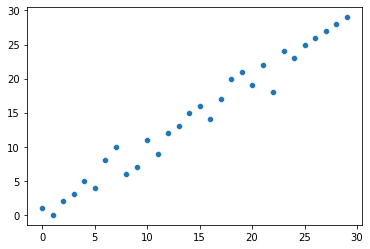

In [726]:
sns.scatterplot(x=dict(zip(y.groupby("team").last().sort_values("record").index, np.arange(30))), y=dict(zip(x.groupby("team").last().sort_values("ranking").index, np.arange(30))))

